In [54]:
# Standard DS imports
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import ast
from sklearn import svm
import time
import datetime

from sklearn.utils import class_weight

# All pytorch dependencies
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split



# all tensorflow dependencies
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [40]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [51]:
# Global var for selecting popularity cutoff
MINIMUM_POPULARITY_LIMIT = 40
MINIMUM_POPULARITY_PERCENTAGE = MINIMUM_POPULARITY_LIMIT / 100

In [52]:
# Initialize the DataFrame
if 'results_df' not in globals():
    results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])

def analyze_algorithm(y_true, y_pred, algorithm):

    global results_df

    # Calculate all scoring metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {round(accuracy, 6)}")
    
    
    precision = precision_score(y_true, y_pred, average='macro')
    print(f"Precision: {round(precision, 6)}")
    
    
    recall = recall_score(y_true, y_pred, average='macro')
    print(f"Recall: {round(recall, 6)}")
    
    
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {round(f1, 6)}")
    

    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_auc, precision_auc)
    print(f"AUPRC: {round(auprc, 6)}")


    # Create a temporary DataFrame for the new row
    new_row_df = pd.DataFrame({
        'algorithm': [algorithm],
        'accuracy': [round(accuracy, 6)],
        'precision': [round(precision, 6)],
        'recall': [round(recall, 6)],
        'f1_score': [round(f1, 6)],
        'AUPRC': [round(auprc, 6)]
    })

    # Use pd.concat() to append the new row
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)


    # Visualize the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    



def print_correlation_matrix(dataframe):
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True,)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()





def predict_and_convert(model, x_data, y_data, cutoff):

    y_scores = model.predict(x_data)
    y_pred = (y_scores > cutoff).astype(int)
    y_data = (y_data > cutoff).astype(int)
    return y_data, y_pred





def find_best_kernel_value(is_classifier, x_train, y_train, x_test, y_test):
    k_values = range(1,25,1)
    train_scores = []
    test_scores = []
    scores_dict = {}

    for k in tqdm(k_values):
        model = neighbors.KNeighborsClassifier(k) if is_classifier else neighbors.KNeighborsRegressor(k)
        model.fit(x_train, y_train.values.ravel())

        y_train_predicted = model.predict(x_train)
        y_test_predicted = model.predict(x_test)

        if is_classifier:
            train_scores.append(f1_score(y_train, y_train_predicted, average='macro'))
            test_score = f1_score(y_test, y_test_predicted, average='macro')
        else:
            y_train_binary = (y_train >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_train_predicted_binary = (y_train_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_binary = (y_test >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_predicted_binary = (y_test_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            
            # Then, compute the accuracy
            train_scores.append(f1_score(y_train_binary, y_train_predicted_binary, average='macro'))
            test_score = f1_score(y_test_binary, y_test_predicted_binary, average='macro')

        test_scores.append(test_score)
        scores_dict[k] = test_score

    plt.plot(k_values, train_scores, 'r-s', label='Train')
    plt.plot(k_values, test_scores, 'b-o', label='Test')
    plt.legend()
    plt.show()

    best_k = max(scores_dict, key=scores_dict.get)
    print(f"The best k value is : {best_k} with score: {scores_dict[best_k]}")

    return best_k




@keras.saving.register_keras_serializable()
def f1_score_nn(y_true, y_pred):
    # Calculate Precision and Recall
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_pred, 0, 1)) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_true, 0, 1)) + K.epsilon())

    # Calculate F1 Score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_val

tracks.csv read in successfully as a dataframe


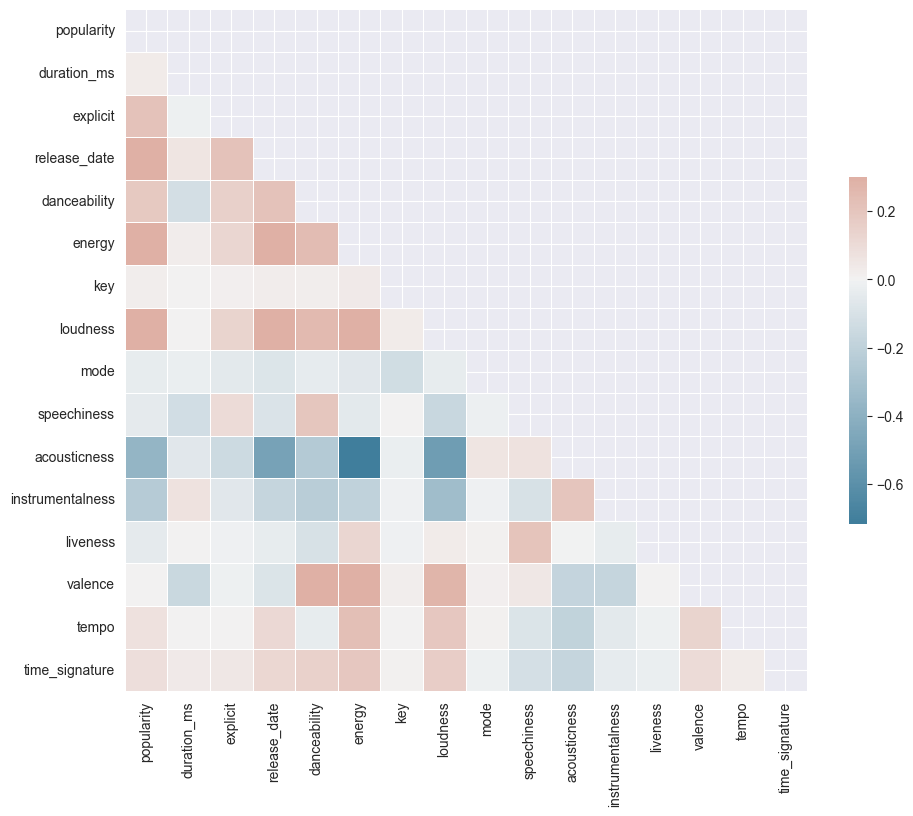

100%|██████████| 24/24 [07:59<00:00, 19.98s/it]


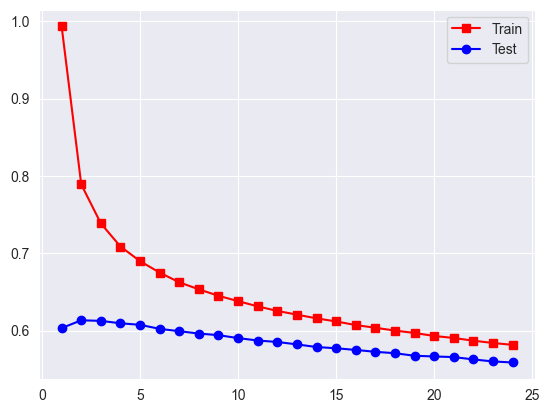

The best k value is : 2 with score: 0.6132694206269218
KNN-Regressor Training...
KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.849439
Precision: 0.809651
Recall: 0.773419
F1 Score: 0.788532
AUPRC: 0.728323


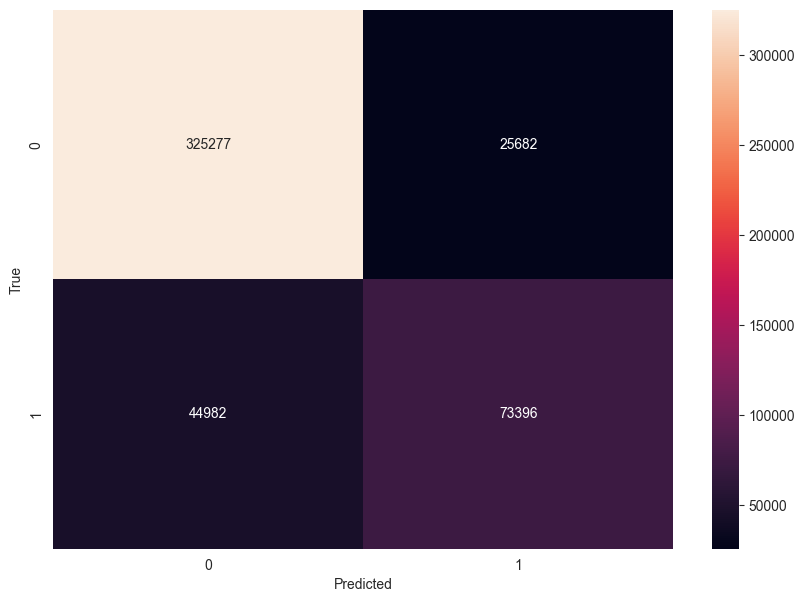


scores for the testing set:
Accuracy: 0.723612
Precision: 0.619185
Recall: 0.606557
F1 Score: 0.611343
AUPRC: 0.483369


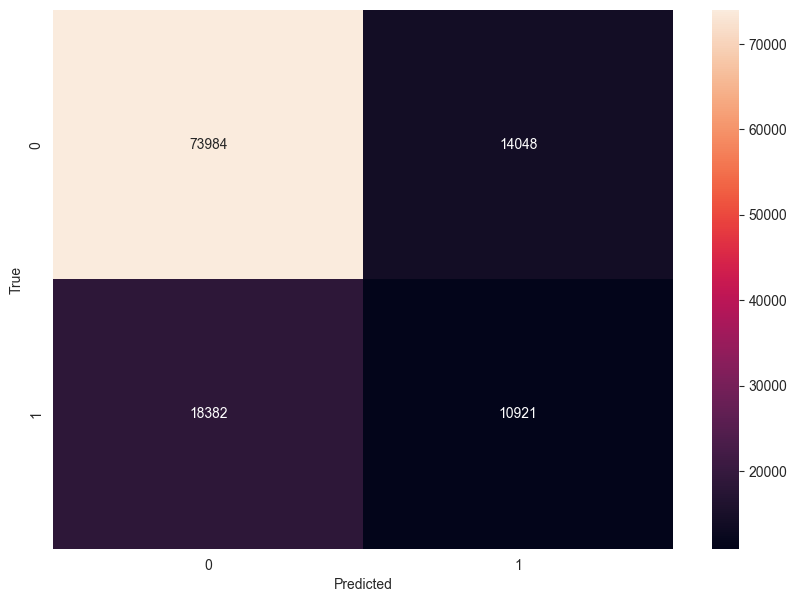

100%|██████████| 24/24 [09:10<00:00, 22.95s/it]


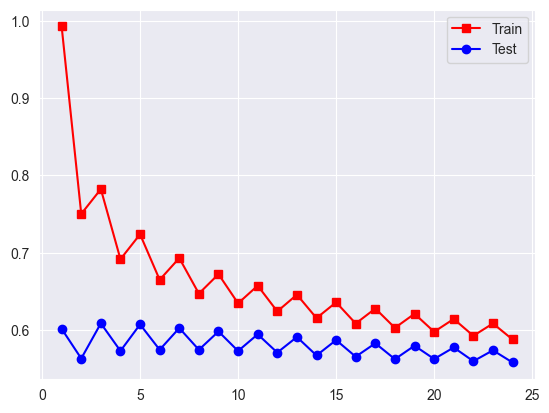

The best k value is : 3 with score: 0.6086874364841228
KNN-Classifier Training...
KNN-Classifier Fitted

scores for the training set:
Accuracy: 0.846488
Precision: 0.807282
Recall: 0.76545
F1 Score: 0.782349
AUPRC: 0.721586


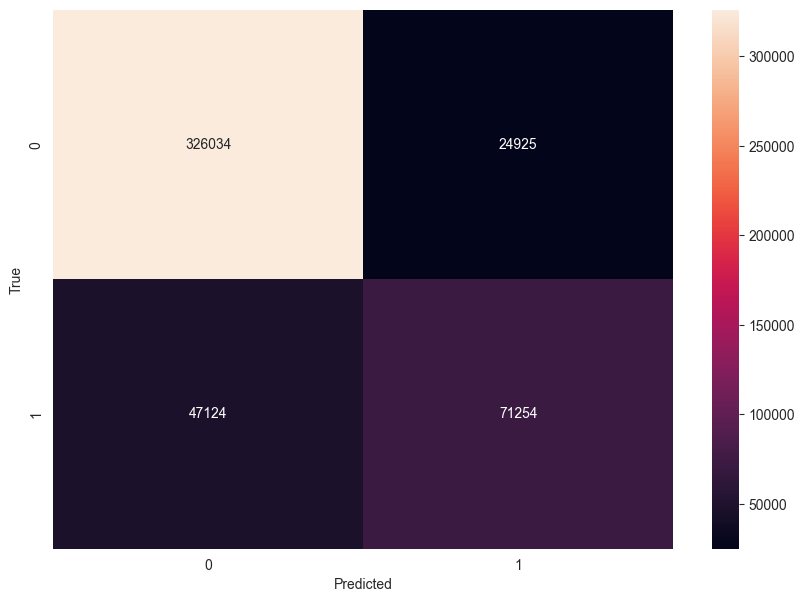


scores for the testing set:
Accuracy: 0.724541
Precision: 0.618331
Recall: 0.603351
F1 Score: 0.608687
AUPRC: 0.479183


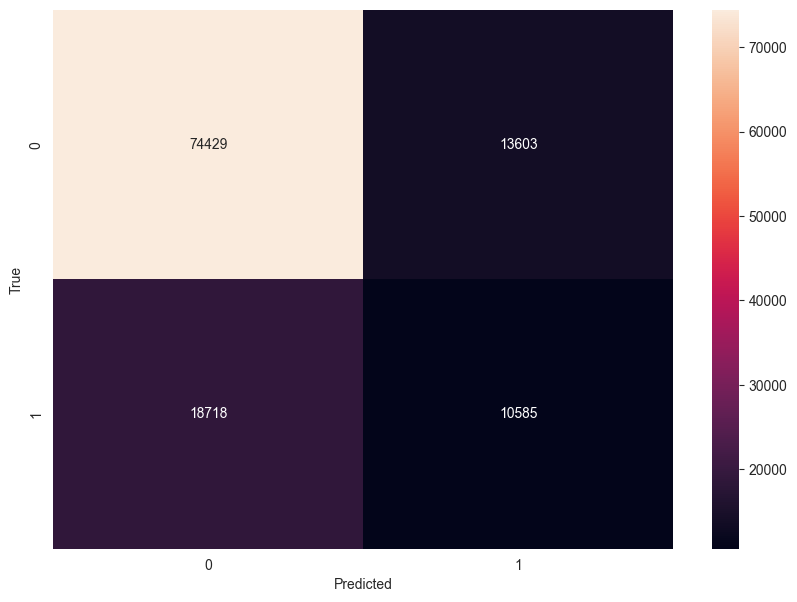

Epoch 1/50
4641/4694 [============================>.] - ETA: 0s - loss: 1.2358 - f1_score_nn: 0.4911
Epoch 1: val_f1_score_nn improved from -inf to 0.51080, saving model to best_model.keras
4694/4694 [==============================] - 4s 753us/step - loss: 1.2353 - f1_score_nn: 0.4914 - val_loss: 0.6088 - val_f1_score_nn: 0.5108
Epoch 2/50
4626/4694 [============================>.] - ETA: 0s - loss: 1.1874 - f1_score_nn: 0.5137
Epoch 2: val_f1_score_nn improved from 0.51080 to 0.52092, saving model to best_model.keras
4694/4694 [==============================] - 3s 741us/step - loss: 1.1874 - f1_score_nn: 0.5136 - val_loss: 0.5925 - val_f1_score_nn: 0.5209
Epoch 3/50
4643/4694 [============================>.] - ETA: 0s - loss: 1.1756 - f1_score_nn: 0.5199
Epoch 3: val_f1_score_nn did not improve from 0.52092
4694/4694 [==============================] - 3s 738us/step - loss: 1.1755 - f1_score_nn: 0.5200 - val_loss: 0.6354 - val_f1_score_nn: 0.5158
Epoch 4/50
4684/4694 [=================

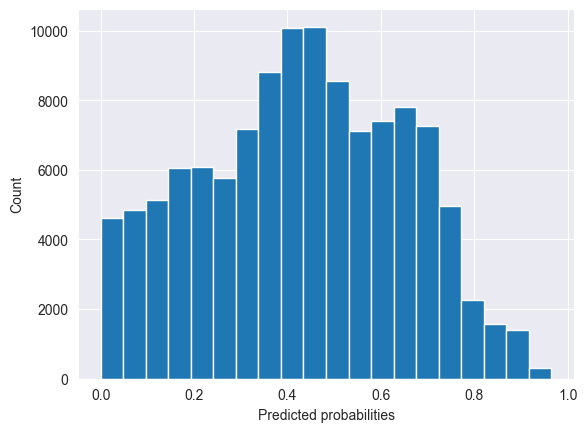

14667/14667 [==============================] - 3s 230us/step

scores for the Training set:
Accuracy: 0.605993
Precision: 0.638677
Recall: 0.681019
F1 Score: 0.591861
AUPRC: 0.624238


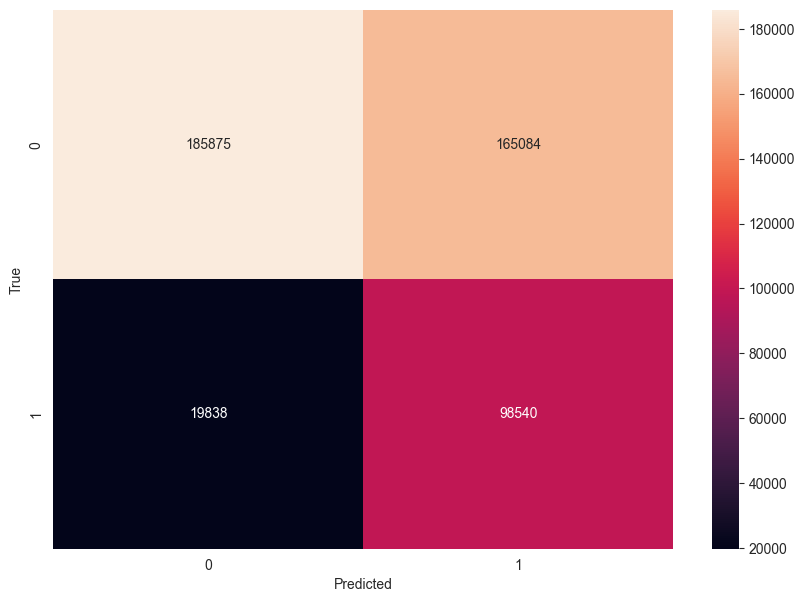

3667/3667 [==============================] - 1s 251us/step

scores for the Testing set:
Accuracy: 0.602727
Precision: 0.636187
Recall: 0.678862
F1 Score: 0.588223
AUPRC: 0.621032


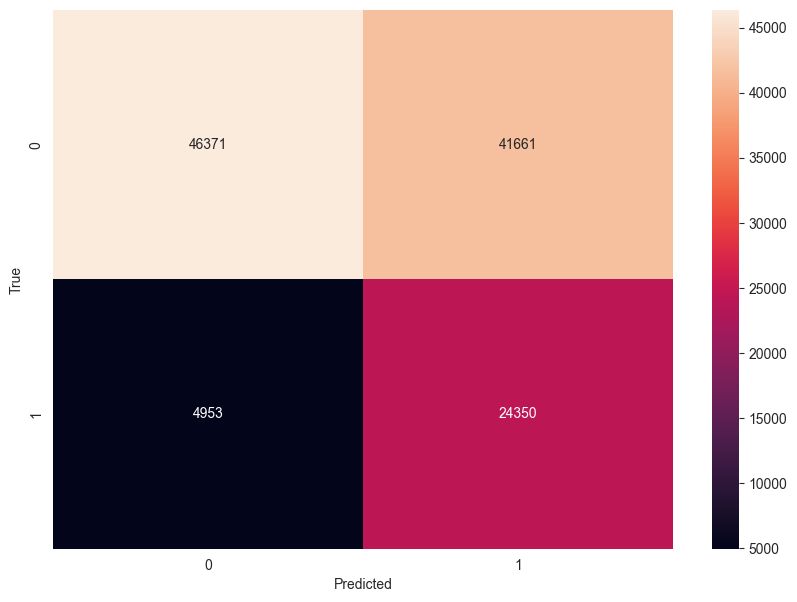

Decision Tree Classifier Training...
Decision Tree Classifier Fitted

scores for the training set:
Accuracy: 0.994803
Precision: 0.995972
Recall: 0.990255
F1 Score: 0.993072
AUPRC: 0.99207


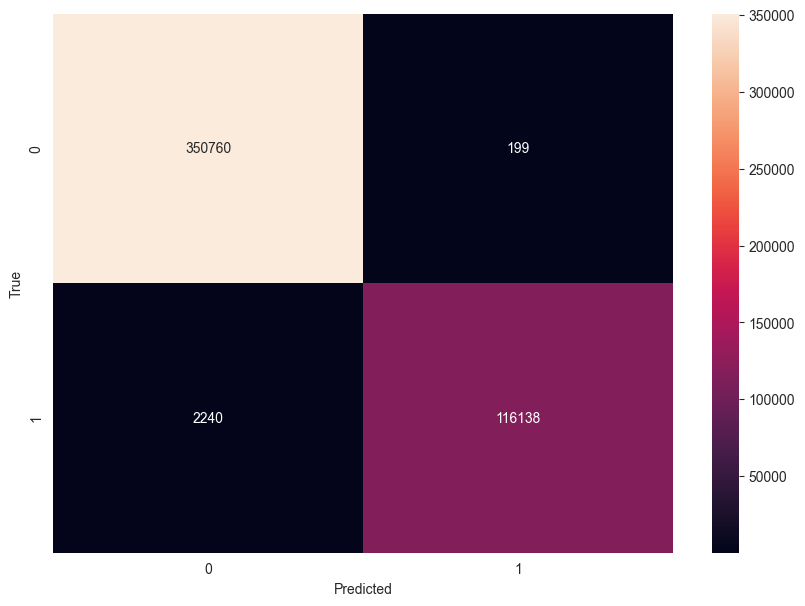


scores for the testing set:
Accuracy: 0.703217
Precision: 0.608715
Recall: 0.61218
F1 Score: 0.610301
AUPRC: 0.491391


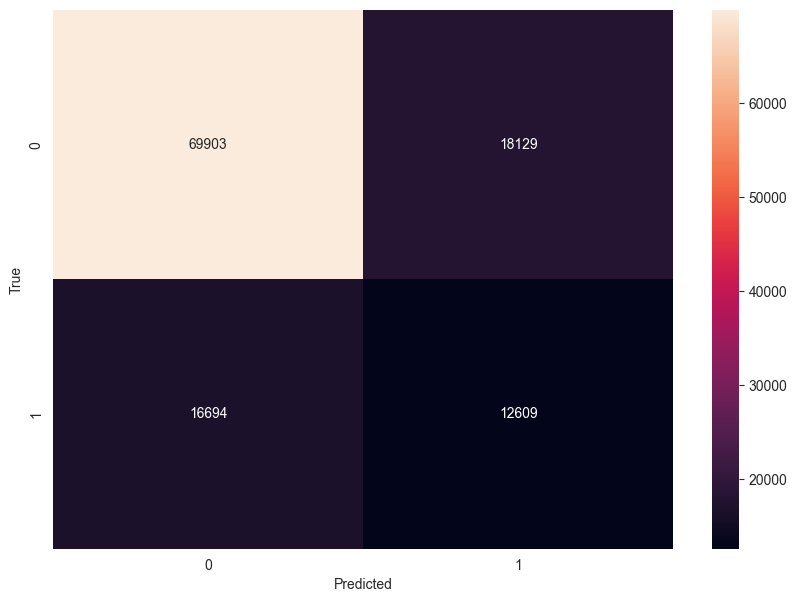

Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.994803
Precision: 0.994766
Recall: 0.991439
F1 Score: 0.993089
AUPRC: 0.991607


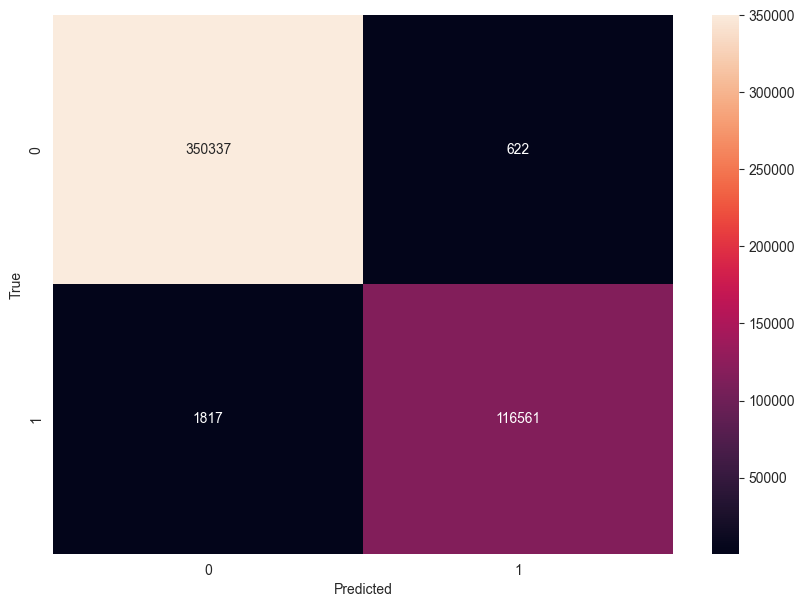


scores for the testing set:
Accuracy: 0.788213
Precision: 0.729693
Recall: 0.634208
F1 Score: 0.652364
AUPRC: 0.573176


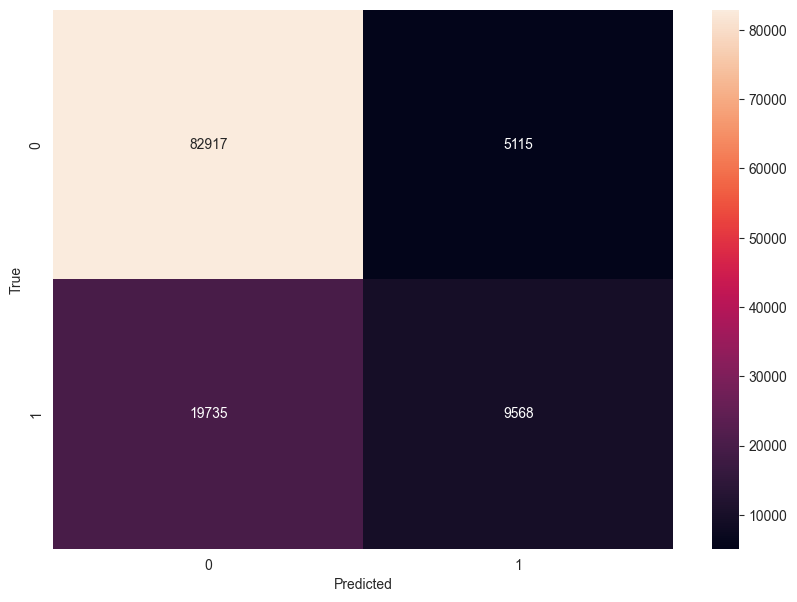

dataset.csv read in successfully as a dataframe


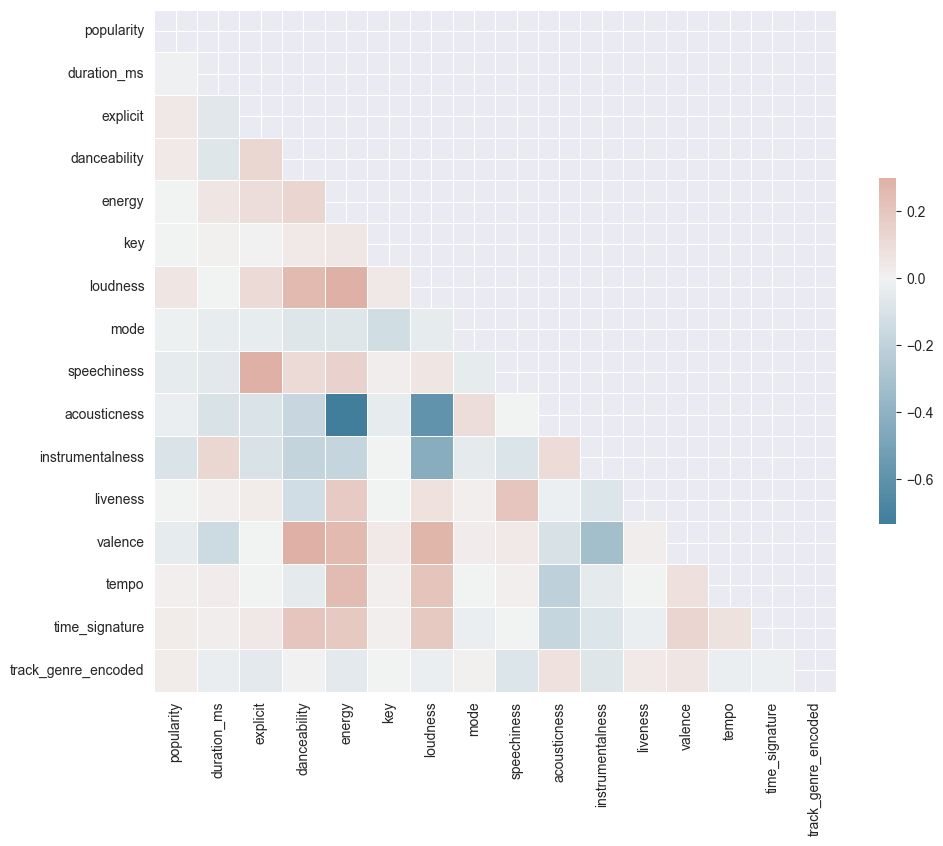

100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


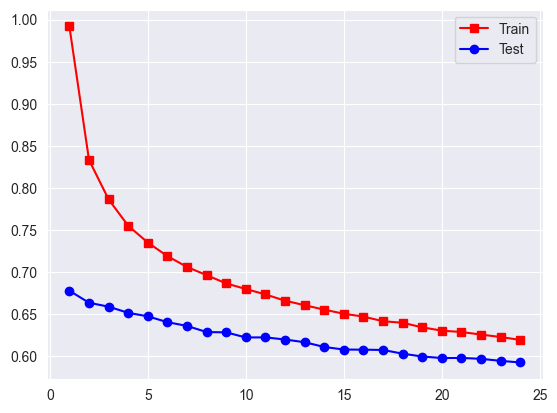

The best k value is : 1 with score: 0.6779109238334349
KNN-Regressor Training...
KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.992007
Precision: 0.991656
Recall: 0.991827
F1 Score: 0.991741
AUPRC: 0.992142


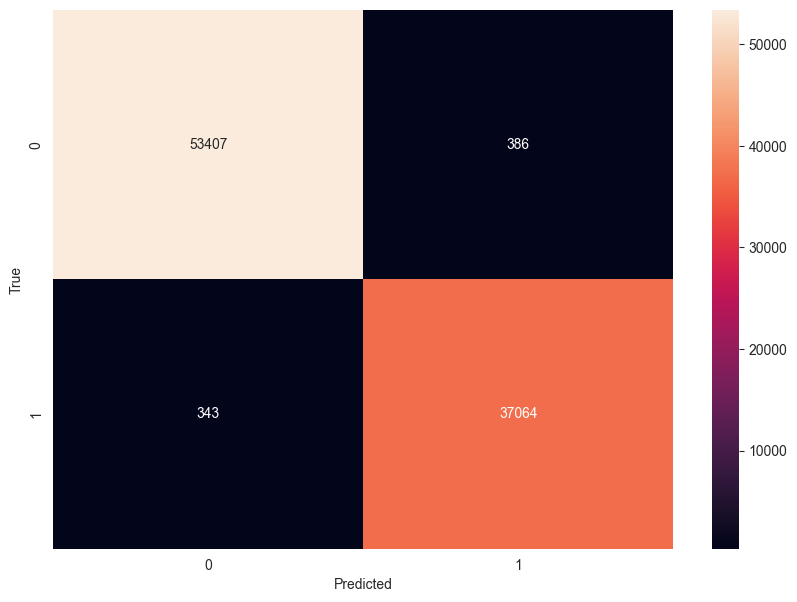


scores for the testing set:
Accuracy: 0.685307
Precision: 0.674059
Recall: 0.674426
F1 Score: 0.674237
AUPRC: 0.692175


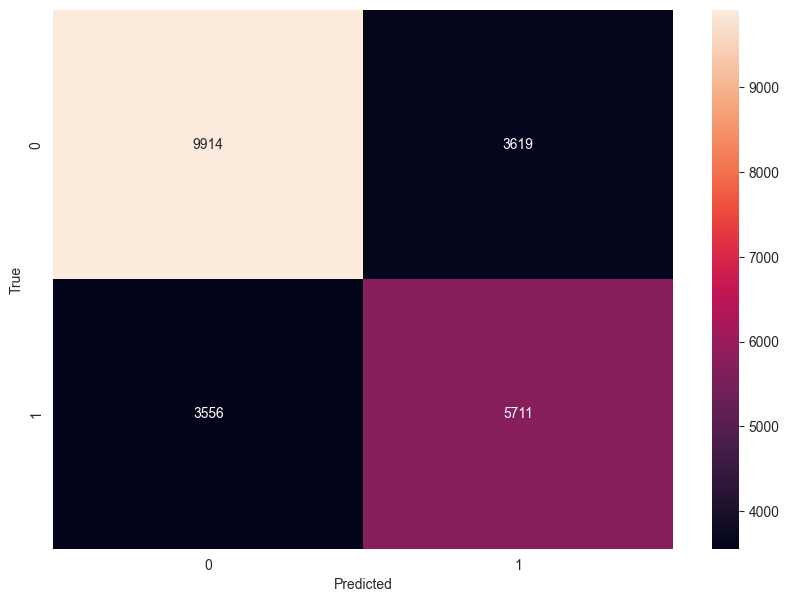

100%|██████████| 24/24 [00:54<00:00,  2.26s/it]


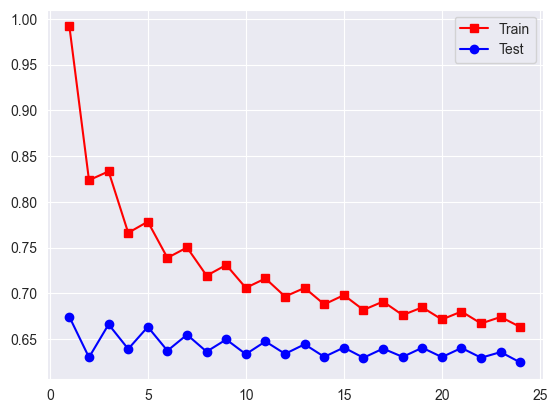

The best k value is : 1 with score: 0.674236933171741
KNN-Classifier Training...
KNN-Classifier Fitted

scores for the training set:
Accuracy: 0.992007
Precision: 0.991656
Recall: 0.991827
F1 Score: 0.991741
AUPRC: 0.992142


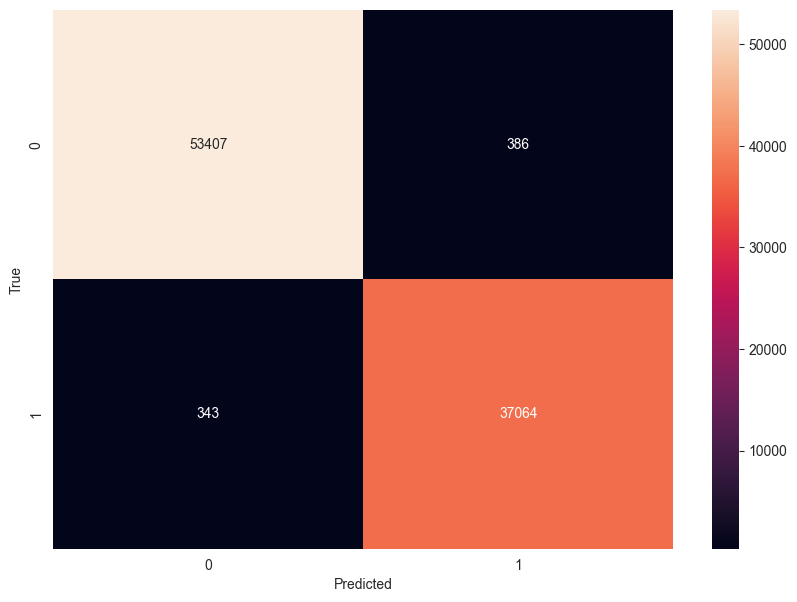


scores for the testing set:
Accuracy: 0.685307
Precision: 0.674059
Recall: 0.674426
F1 Score: 0.674237
AUPRC: 0.692175


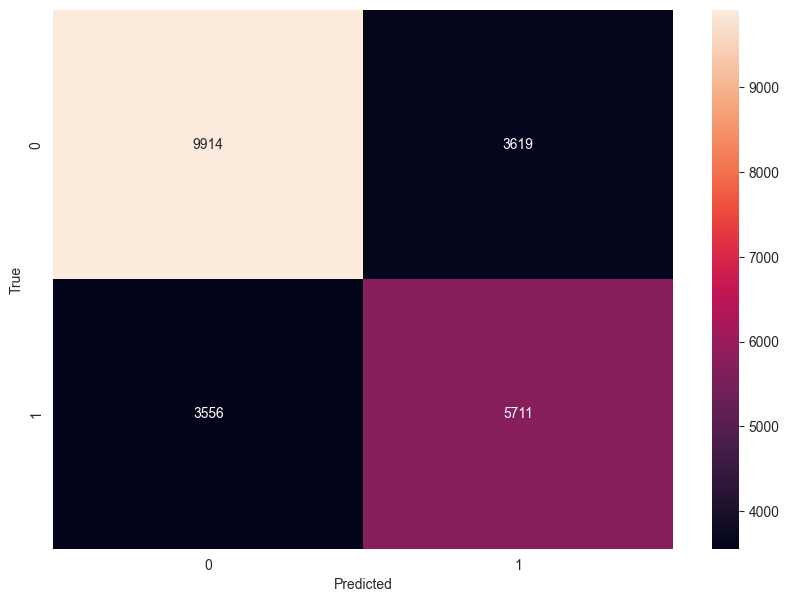

YIIIIIPPPPPEEEEEEEEE
SVM-Classifier Training...
SVM-Classifier Fitted

scores for the training set:
Accuracy: 0.663651
Precision: 0.657029
Recall: 0.624071
F1 Score: 0.621865
AUPRC: 0.645853


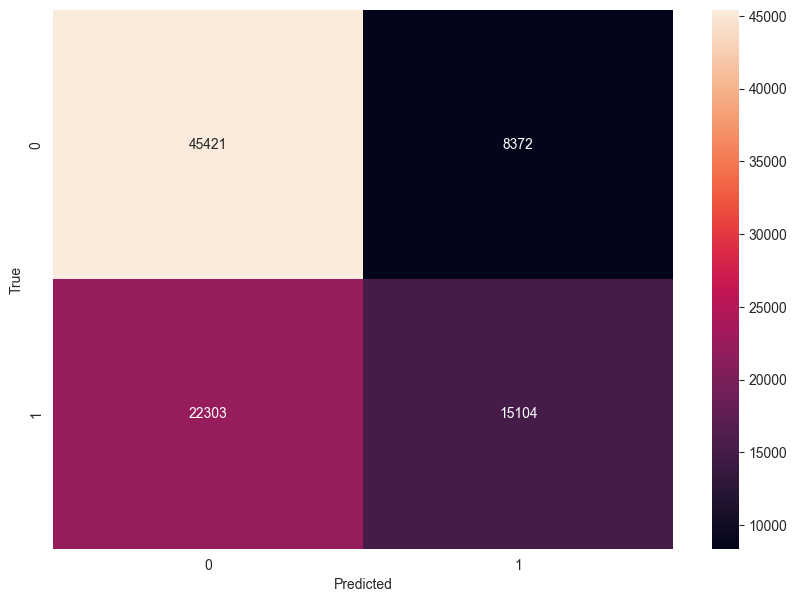


scores for the testing set:
Accuracy: 0.64943
Precision: 0.636604
Recall: 0.606837
F1 Score: 0.603245
AUPRC: 0.621113


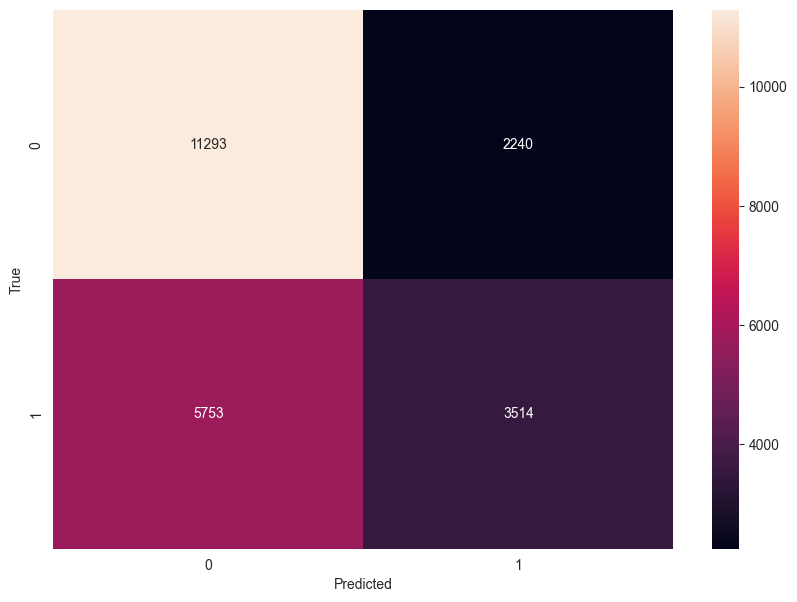

Epoch 1/50
866/912 [===========================>..] - ETA: 0s - loss: 1.4192 - f1_score_nn: 0.4000
Epoch 1: val_f1_score_nn improved from -inf to 0.56093, saving model to best_model.keras
912/912 [==============================] - 1s 843us/step - loss: 1.4180 - f1_score_nn: 0.3984 - val_loss: 0.7012 - val_f1_score_nn: 0.5609
Epoch 2/50
869/912 [===========================>..] - ETA: 0s - loss: 1.3784 - f1_score_nn: 0.4434
Epoch 2: val_f1_score_nn improved from 0.56093 to 0.57094, saving model to best_model.keras
912/912 [==============================] - 1s 776us/step - loss: 1.3787 - f1_score_nn: 0.4444 - val_loss: 0.6979 - val_f1_score_nn: 0.5709
Epoch 3/50
872/912 [===========================>..] - ETA: 0s - loss: 1.3726 - f1_score_nn: 0.4836
Epoch 3: val_f1_score_nn did not improve from 0.57094
912/912 [==============================] - 1s 776us/step - loss: 1.3724 - f1_score_nn: 0.4855 - val_loss: 0.6746 - val_f1_score_nn: 0.4039
Epoch 4/50
869/912 [===========================>..]

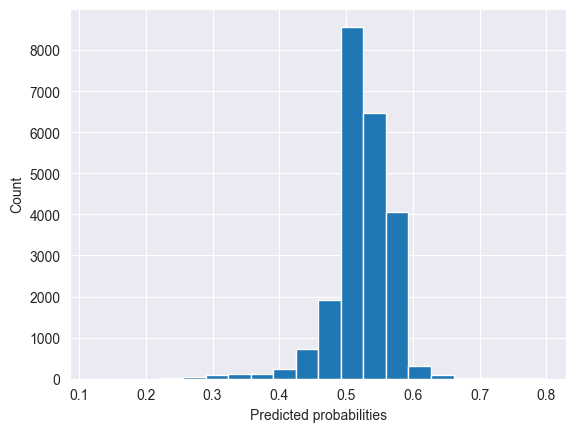

2850/2850 [==============================] - 1s 264us/step

scores for the Training set:
Accuracy: 0.422917
Precision: 0.615514
Recall: 0.509434
F1 Score: 0.319397
AUPRC: 0.704747


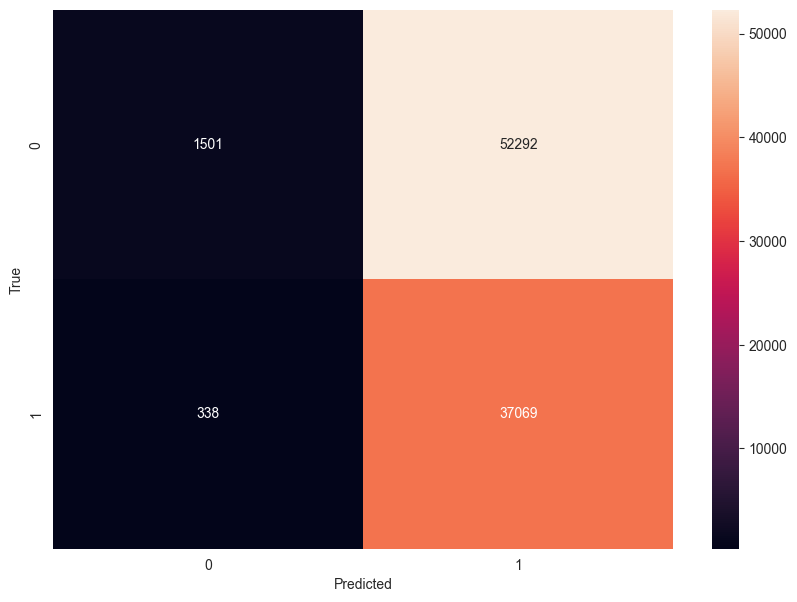

713/713 [==============================] - 0s 289us/step

scores for the Testing set:
Accuracy: 0.418158
Precision: 0.610905
Recall: 0.508487
F1 Score: 0.315272
AUPRC: 0.702716


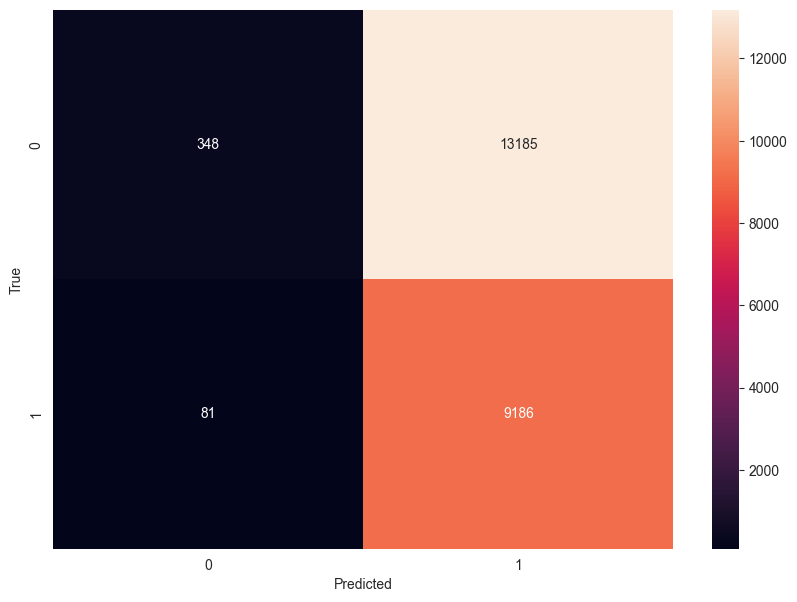

Decision Tree Classifier Training...
Decision Tree Classifier Fitted

scores for the training set:
Accuracy: 0.993662
Precision: 0.994607
Recall: 0.992343
F1 Score: 0.993436
AUPRC: 0.995346


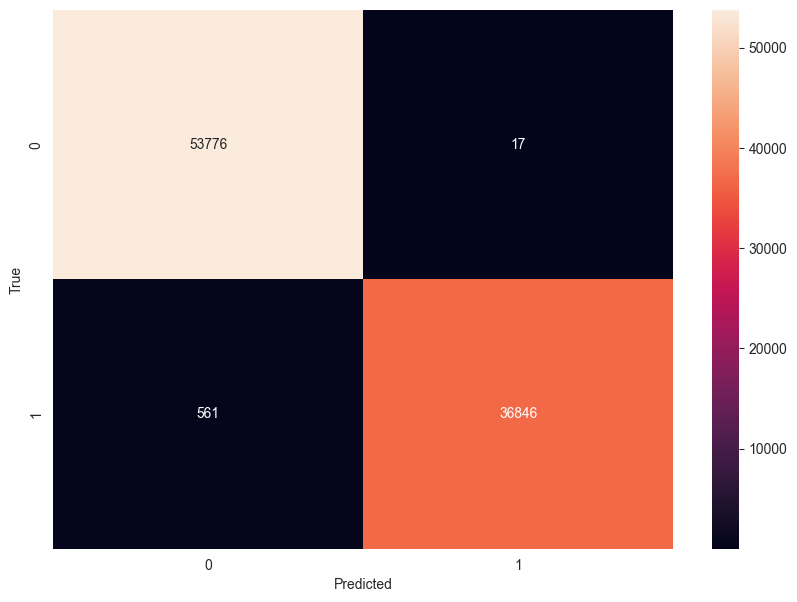


scores for the testing set:
Accuracy: 0.737763
Precision: 0.728196
Recall: 0.727442
F1 Score: 0.727805
AUPRC: 0.74236


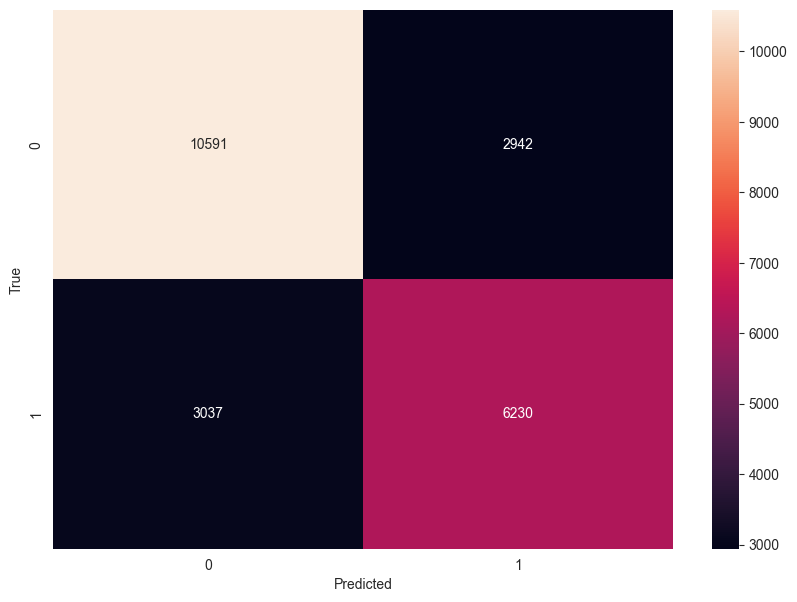

Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.993662
Precision: 0.993929
Recall: 0.992974
F1 Score: 0.993445
AUPRC: 0.994486


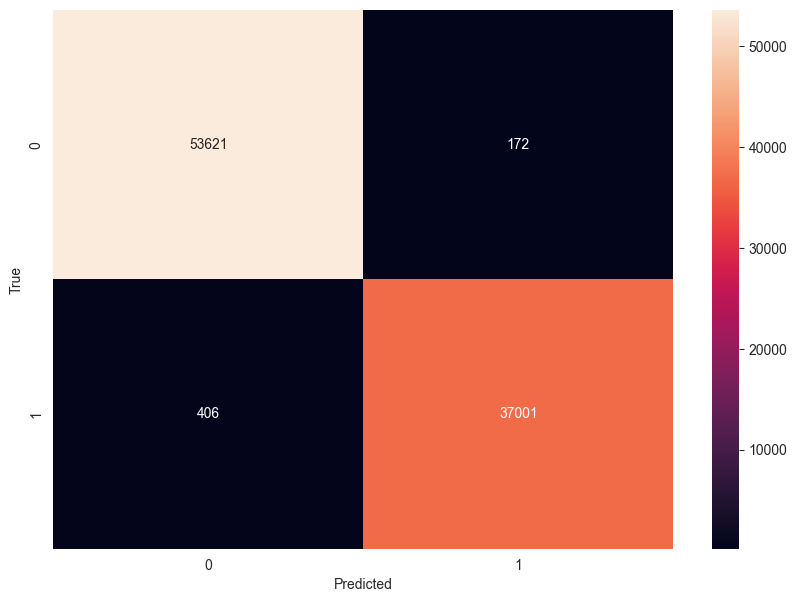


scores for the testing set:
Accuracy: 0.815439
Precision: 0.812572
Recall: 0.801225
F1 Score: 0.805516
AUPRC: 0.819335


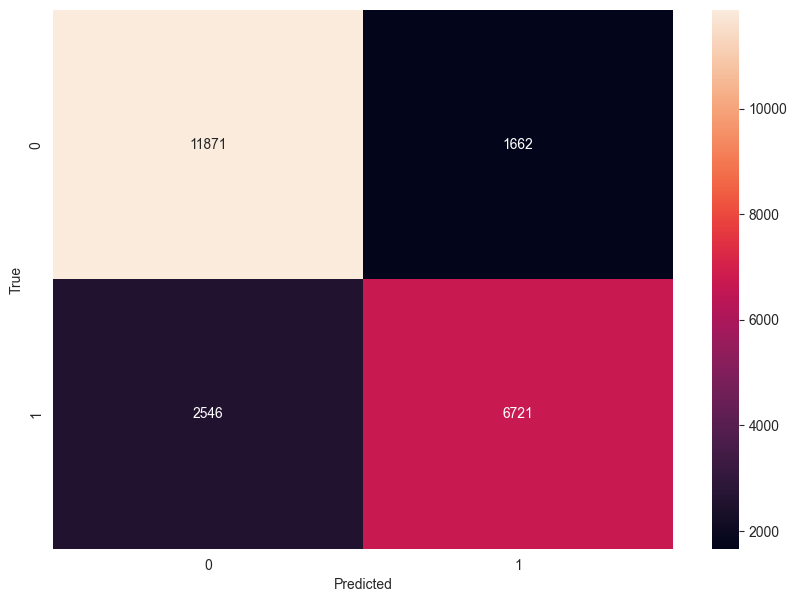


Execution time: 1738.1782231330872 seconds


In [53]:
# Putting file specific info into arrays for easier access
files = ['tracks.csv', 'dataset.csv']
inputs = [
            [ 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit'],
                  
            ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
        ]
target = ['popularity']

start_time = time.time()

for i in range(len(files)):

    

    df = pd.read_csv('./'+files[i])
    print(files[i], 'read in successfully as a dataframe')
    # File specific cleaning
    
    # Data cleaning for tracks.csv
    if i == 0:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
        df = df.drop(columns=['id', 'name', 'artists', 'id_artists'])
        
    # Data cleaning for dataset.csv
    if i == 1:
        df['track_genre_encoded'] = LabelEncoder().fit_transform(df['track_genre'])
        df = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])
        
       
    print_correlation_matrix(df)

    xtrain, xtest, ytrain, ytest = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)

    # Training Model 1 KNN-Regressor
    kernelNumber = find_best_kernel_value(False, xtrain, ytrain, xtest, ytest)


    print('KNN-Regressor Training...')
    modelOne = neighbors.KNeighborsRegressor(kernelNumber)
    modelOne.fit(xtrain, ytrain)
    print('KNN-Regressor Fitted')

    # Apply a same threshold to train predictions
    y_train, y_train_pred = predict_and_convert(modelOne, xtrain, ytrain, MINIMUM_POPULARITY_LIMIT)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred, files[i]+'KNN-Regressor Training')

    y_test, y_test_pred = predict_and_convert(modelOne, xtest, ytest, MINIMUM_POPULARITY_LIMIT)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred, files[i]+'KNN-Regressor Testing')





    # Training Model 2 KNN-Classifier
    y_train_two = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test_two = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)

    kernelNumber = find_best_kernel_value(True, xtrain, y_train_two, xtest, y_test_two)

    print('KNN-Classifier Training...')
    modelTwo = neighbors.KNeighborsClassifier(kernelNumber)
    modelTwo.fit(xtrain, y_train_two.values.ravel())
    print('KNN-Classifier Fitted')

    y_train_pred = modelTwo.predict(xtrain)
    print('\nscores for the training set:')
    analyze_algorithm(y_train_two, y_train_pred,files[i]+'KNN-Classifier Training')

    # Apply a same threshold to test predictions
    y_test_pred = modelTwo.predict(xtest)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test_two, y_test_pred,files[i]+'KNN-Classifier Testing')

    


    # Training Model 3 SVM-rbf
    # The first dataset is too big to reasonably run with SVM as it generally take O(n^3*d) time for training
    if i == 1:
        # Training Model 3 SVM
        print('YIIIIIPPPPPEEEEEEEEE')
        y_train = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
        y_test = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)

        sc = StandardScaler()
        X_train = sc.fit_transform(xtrain)
        X_test = sc.transform(xtest)
 
        # Training the SVM model on the Training set using a linear kernel
        print('SVM-Classifier Training...')
        modelThree = SVC(kernel = 'rbf', random_state = 42)
        modelThree.fit(X_train, y_train.values.ravel())  
        print('SVM-Classifier Fitted')

        # Predicting the results
        print('\nscores for the training set:')
        y_pred = modelThree.predict(X_train)
        analyze_algorithm(y_train, y_pred, files[i]+'SVM Training')

        print('\nscores for the testing set:')
        y_pred = modelThree.predict(X_test)
        analyze_algorithm(y_test, y_pred, files[i]+'SVM Testing')






    # Training Model 4 Convolution Neural Network
    X_train, X_test, y_train, y_test = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    y_train = (y_train > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test = (y_test > MINIMUM_POPULARITY_LIMIT).astype(int)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    # Define the neural network structure
    modelFour = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    modelFour.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[f1_score_nn])

    y_train_numpy = y_train.to_numpy().astype('int64')
    unique_classes, class_counts = np.unique(y_train_numpy, return_counts=True)
    class_weights_dict = {class_label: len(y_train_numpy) / count for class_label, count in zip(unique_classes, class_counts)}


    # Define EarlyStopping and ModelCheckpoint callbacks.
    es = EarlyStopping(monitor='val_f1_score_nn', mode='max', verbose=1, patience=5)
    mc = ModelCheckpoint('best_model.keras', monitor='val_f1_score_nn', mode='max', verbose=1, save_best_only=True, save_format='tf')
    # callbacks=[es, mc]


    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # callbacks=[tensorboard_callback, es, mc]
    # Pass class weights and callbacks into model.fit().
    modelFour.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=100,
                  class_weight=class_weights_dict, callbacks=[es, mc])

    
    
    # Load the best model
    modelFour = keras.models.load_model('best_model.keras')
    


    # Make predictions
    predictions = modelFour.predict(X_test)
    plt.hist(predictions, bins=20)
    plt.xlabel('Predicted probabilities')
    plt.ylabel('Count')
    plt.show()


    predictions = (modelFour.predict(X_train) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    print('\nscores for the Training set:')
    analyze_algorithm(y_train, predictions,files[i]+'Neural Network Training')


    predictions = (modelFour.predict(X_test) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    print('\nscores for the Testing set:')
    analyze_algorithm(y_test, predictions,files[i]+'Neural Network Testing')
    
    
    
    
    # Training Model 5 Decision Tree Classifier
    modelFive = DecisionTreeClassifier()
    print('Decision Tree Classifier Training...')
    modelFive.fit(X_train, y_train.values.ravel())
    print('Decision Tree Classifier Fitted')
    
    y_train_pred = modelFive.predict(X_train)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred,files[i]+'Decision Tree Classifier Training')
    
    y_test_pred = modelFive.predict(X_test)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred,files[i]+'Decision Tree Classifier Testng')





    # Training Model 6 Random Forest Classifier
    modelSix = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    print('Random Forest Classifier Training...')
        # Define the cross-validation procedure
    cv = StratifiedKFold(n_splits=5) # 5-fold cross-validation. 
    
    # Define the scoring method by make_scorer
    f1 = make_scorer(f1_score , average='macro')
    
    # Perform cross-validation with the f1 macro as a scoring method
    n_scores = cross_val_score(modelSix, X_train, y_train.values.ravel(), scoring=f1, cv=cv, n_jobs=-1)
    print('Random Forest Classifier Fitted')

    y_train_pred = modelSix.predict(X_train)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred,files[i]+'Random Forest Classifier Training')

    y_test_pred = modelSix.predict(X_test)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred,files[i]+'Random Forest Classifier Testng')
    
    
    
    

# End timing and print the result
end_time = time.time()

print("\nExecution time: {} seconds".format(end_time - start_time))

results_df.to_csv('resultsof40.csv', index=False)
    

In [38]:
# %tensorboard --logdir logs/fit
!pip install --upgrade pandas